# PEEC - Estimation of the effect of lensing in photometric galaxy surveys 

In [1]:
import numpy as np
import scipy as sc
import pyccl as ccl
import matplotlib.pyplot as plt
import math
import time
# from icecream import ic

PyCCL documentation - https://ccl.readthedocs.io/en/latest/api/pyccl.cosmology.html#pyccl.cosmology.Cosmology.correlation_3d

PyCCL code - https://github.com/LSSTDESC/CCLX/blob/master/Angular%20cross-correlations.ipynb

$$\begin{split}
    w^{ab}(\theta) = \sum_l \frac{2l+1}{4\pi} C_l^{ab} P_l(\cos\theta)\\
\end{split}$$

$$\begin{split}
    C^{ab}_l = 4\pi \int_0^{+\infty} \frac{P_\phi(k)}{k} \Delta_l^{NC, a} \Delta_l^{NC, b} \;dk\\
\end{split}$$

$$\begin{split}
    \Delta^{NC} \equiv \Delta^D + \Delta^{RSD} + \Delta^{LM}\\
\end{split}$$

### 3D Correlation function - $\xi(r)$

Cosmology object has stored P(K) = True


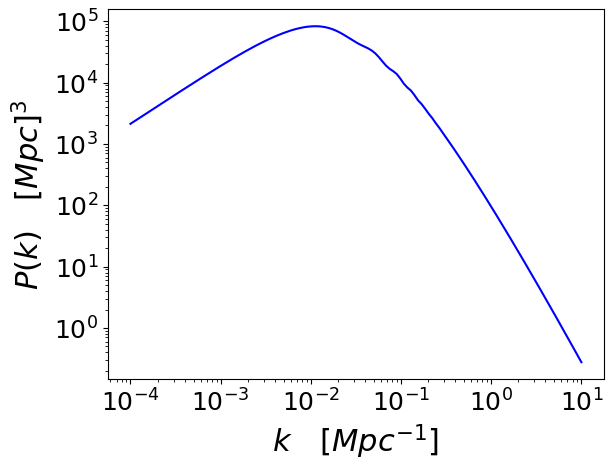


sigma8 = 0.8402187282371845


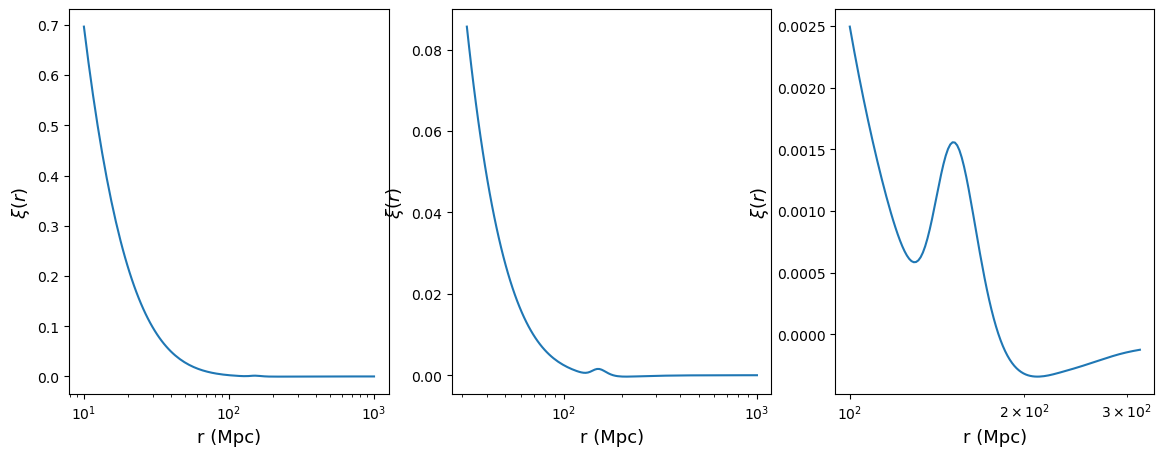

In [2]:
# Define a set of cosmological parameters
cosmo3D = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1*10**-9, n_s=0.96)


# Define wavenumber, k, and scale factor, a
kmin, kmax, nk = 10**-4, 10, 128
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
a_0 = 1.0 # Scale factor a(t_0)=1

# Determine the linear Power spectrum for this cosmological parameters
Pk_lin = ccl.linear_matter_power(cosmo3D, ks, a_0)   # this saves the linear P(k) in this cosmology object
print("Cosmology object has stored P(K) =",cosmo3D.has_linear_power)

plt.plot(ks, Pk_lin, 'b-')
# plt.plot(k, pk_nl, 'r-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel(r'$P(k)\quad[Mpc]^3$', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Power Spectrum normalization, sigma8
ccl.sigma8(cosmo3D)
print("\nsigma8 =",cosmo3D['sigma8'])

# Helper to retrieve the right Pk2D object.
Pk2D = ccl.parse_pk(cosmo3D)  

rs1 = np.logspace(1, 3, nk)  # in Mpc
rs2 = np.logspace(1.5, 3, nk)
rs3 = np.logspace(2, 2.5, nk)

xi_3D_1 = ccl.correlation_3d(cosmo3D, r=rs1, a=a_0, p_of_k_a=Pk2D ) 
xi_3D_2 = ccl.correlation_3d(cosmo3D, r=rs2, a=a_0, p_of_k_a=Pk2D ) 
xi_3D_3 = ccl.correlation_3d(cosmo3D, r=rs3, a=a_0, p_of_k_a=Pk2D ) 

fig, axis = plt.subplots(ncols=3,nrows=1,figsize=(14,5))
axis[0].plot(rs1, xi_3D_1, label='Clustering')
axis[0].set_xscale('log')
axis[0].set_xlabel(r'r (Mpc)',fontsize=13)
axis[0].set_ylabel(r'$\xi (r)$',fontsize=13)
axis[1].plot(rs2, xi_3D_2, label='Clustering')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'r (Mpc)',fontsize=13)
axis[1].set_ylabel(r'$\xi (r)$',fontsize=13)
axis[2].plot(rs3, xi_3D_3, label='Clustering')
axis[2].set_xscale('log')
axis[2].set_xlabel(r'r (Mpc)',fontsize=13)
axis[2].set_ylabel(r'$\xi (r)$',fontsize=13)
plt.show()

### Angular correlation function $w(\theta)$

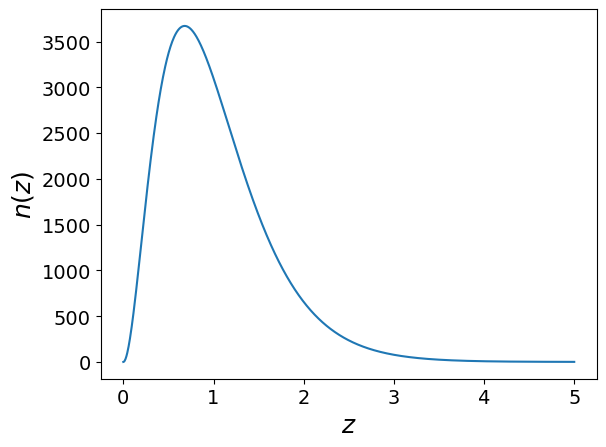

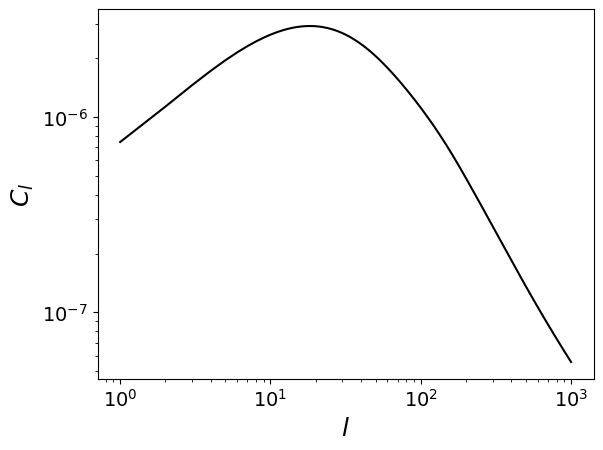

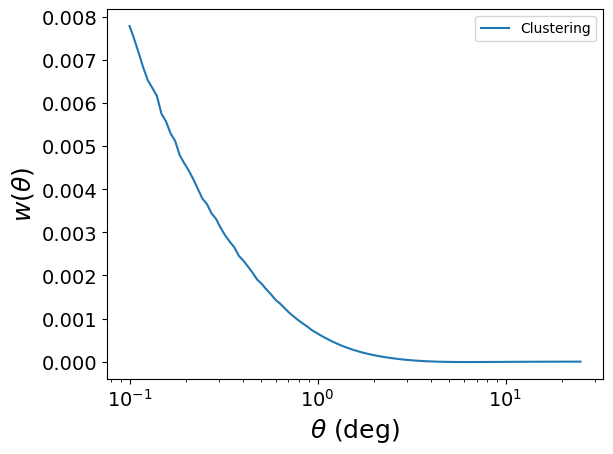

In [3]:
# Definir um tipo de Universo
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)


# Definir uma Distribuição de Galáxias
z = np.linspace(0, 5, 1024)
i_lim = 26.0 # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744 # Constant, used to mimic observation

Ngal = 46. * 100.31  * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution
b = 1.5*np.ones(1024) #Galaxy bias (constant with scale and z)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$n(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(z, dNdz)
plt.show()


# Criar tracers 
lens1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz)) #CCL automatically normalizes dNdz
clu1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))


# Calcular Poderes espectrais angulares
ells = np.arange(1, 1000)
cls_cluster = ccl.angular_cl(cosmo, clu1, clu1, ells) #Clustering

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ells, cls_cluster, 'k-')
plt.show()


# Calcular Função de correlação
thetas = np.logspace(-1, np.log10(25), 100) # Theta is in degrees
#print("thetas =", thetas)
cosmo2 = cosmo        # A Cosmology object.
ell2 = ells           # Multipoles corresponding to the input angular power spectrum.
C_ell2 = cls_cluster  # Input angular power spectrum.
theta2 = thetas       # Angular separation(s) at which to calculate the angular correlation function (in degrees).
type = "NN"           # Type of correlation function. In this case matter, galaxies
method = "fftlog"     # Method to compute the correlation function.

w_cluster = ccl.correlation(cosmo2, ell=ell2, C_ell=C_ell2, theta=theta2, type='NN', method='fftlog')

plt.plot(thetas, w_cluster, label='Clustering')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)',fontsize=18)
plt.ylabel(r'$w (\theta)$',fontsize=18)
plt.show()

### Usar os 3 tracers do Number Counts

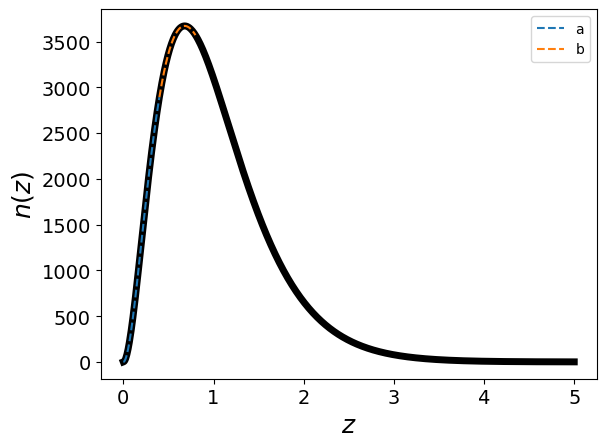

In [4]:
# Definir um tipo de Universo
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

# Definir uma Distribuição de Galáxias
i_lim = 26.0 # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744 # Constant, used to mimic observation
Ngal = 46. * 100.31  * (i_lim - 25.) # Normalisation, galaxies/arcmin^2

# Redshift distribution, p(z)
def p_z(z, z_0):
    return 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0)

Npts = 750
arr_z = np.linspace(0, 5, Npts)
pz0 = p_z(arr_z, z0)
dNdz0 = Ngal * pz0 # Number density distribution

arr_z1 = np.linspace(0, 0.4, Npts)
pz1 = p_z(arr_z1, z0)
dNdz1 = Ngal * pz1 # Number density distribution
b_z1 = 1*np.ones(Npts) #Galaxy bias (constant with scale and z)
s_z1 = 1*np.ones(Npts) #Lensing bias (constant with scale and z)

Npts2 = 750
arr_z2 = np.linspace(0.4, 0.8, Npts2)
pz2 = p_z(arr_z2, z0)
dNdz2 = Ngal * pz2 # Number density distribution
b_z2 = 1*np.ones(Npts2) #Galaxy bias (constant with scale and z)
s_z2 = 1*np.ones(Npts2) #Lensing bias (constant with scale and z)


plt.xlabel('$z$',fontsize=18)
plt.ylabel('$n(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(arr_z,dNdz0, linewidth = 5, color="k")
plt.plot(arr_z1, dNdz1, "--", label="a")
plt.plot(arr_z2, dNdz2, "--", label="b")
plt.legend()
plt.show()

In [5]:
# Criar tracers 
Tracer_NC_D_a       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z1), mag_bias = None, has_rsd=False, n_samples=Npts)
Tracer_NC_D_RSD_a   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z1), mag_bias = None, has_rsd=True, n_samples=Npts)
Tracer_NC_D_RSD_L_a = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z1), mag_bias = (arr_z1,s_z1), has_rsd=True, n_samples=Npts)

Tracer_NC_D_b       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z2), mag_bias = None, has_rsd=False, n_samples=Npts2)
Tracer_NC_D_RSD_b   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z2), mag_bias = None, has_rsd=True, n_samples=Npts2)
Tracer_NC_D_RSD_L_b = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z2), mag_bias = (arr_z2,s_z2), has_rsd=True, n_samples=Npts2)


# Calcular Poderes espectrais angulares
ells = np.arange(1, 2*10**3)
cls_D_aa       = ccl.angular_cl(cosmo, Tracer_NC_D_a, Tracer_NC_D_a, ells)
cls_D_RSD_aa   = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_a, Tracer_NC_D_RSD_a, ells) 
cls_D_RSD_L_aa = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_L_a, Tracer_NC_D_RSD_L_a, ells)

cls_D_ab       = ccl.angular_cl(cosmo, Tracer_NC_D_a, Tracer_NC_D_b, ells)
cls_D_RSD_ab   = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_a, Tracer_NC_D_RSD_b, ells) 
cls_D_RSD_L_ab = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_L_a, Tracer_NC_D_RSD_L_b, ells)

cls_D_bb       = ccl.angular_cl(cosmo, Tracer_NC_D_b, Tracer_NC_D_b, ells)
cls_D_RSD_bb   = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_b, Tracer_NC_D_RSD_b, ells) 
cls_D_RSD_L_bb = ccl.angular_cl(cosmo, Tracer_NC_D_RSD_L_b, Tracer_NC_D_RSD_L_b, ells) 

# Calcular Função de correlação
thetas = np.logspace(-1, np.log10(15), 1000) # Theta is in degrees
w_D_aa       = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_aa, theta=thetas, type='NN', method='fftlog')
w_D_RSD_aa   = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_aa, theta=thetas, type='NN', method='fftlog')
w_D_RSD_L_aa = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_L_aa, theta=thetas, type='NN', method='fftlog')

w_D_ab       = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_ab, theta=thetas, type='NN', method='fftlog')
w_D_RSD_ab   = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_ab, theta=thetas, type='NN', method='fftlog')
w_D_RSD_L_ab = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_L_ab, theta=thetas, type='NN', method='fftlog')

w_D_bb       = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_bb, theta=thetas, type='NN', method='fftlog')
w_D_RSD_bb   = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_bb, theta=thetas, type='NN', method='fftlog')
w_D_RSD_L_bb = ccl.correlation(cosmo, ell=ells, C_ell=cls_D_RSD_L_bb, theta=thetas, type='NN', method='fftlog')

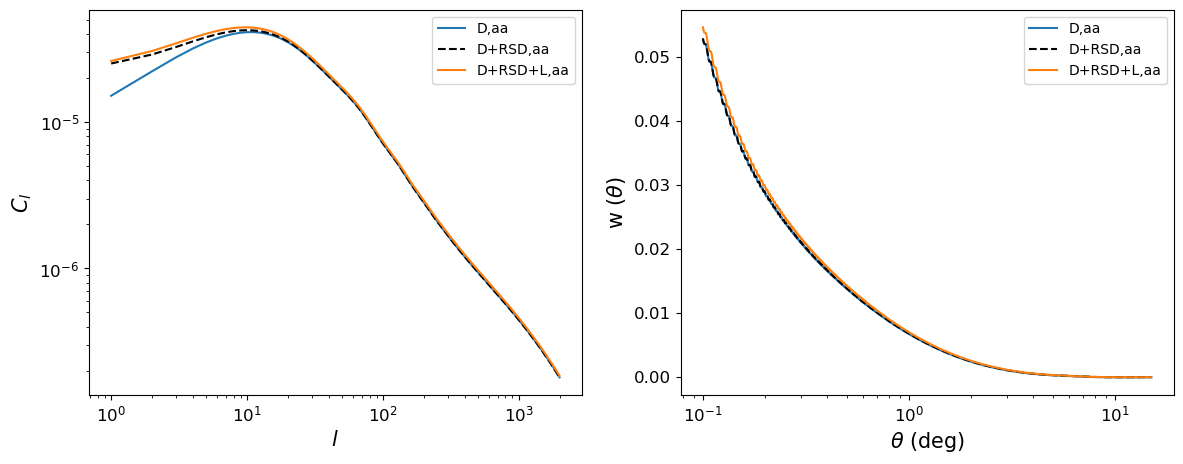

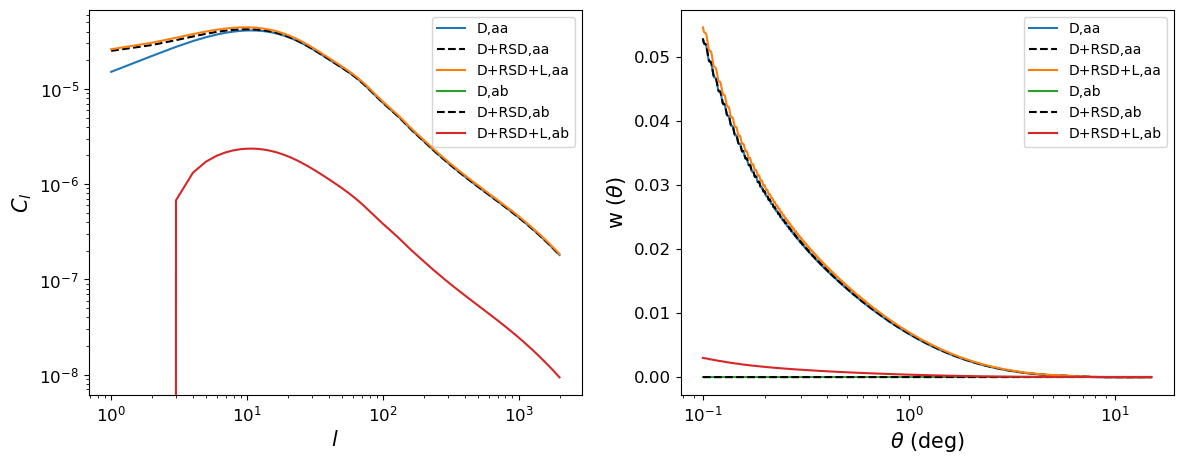

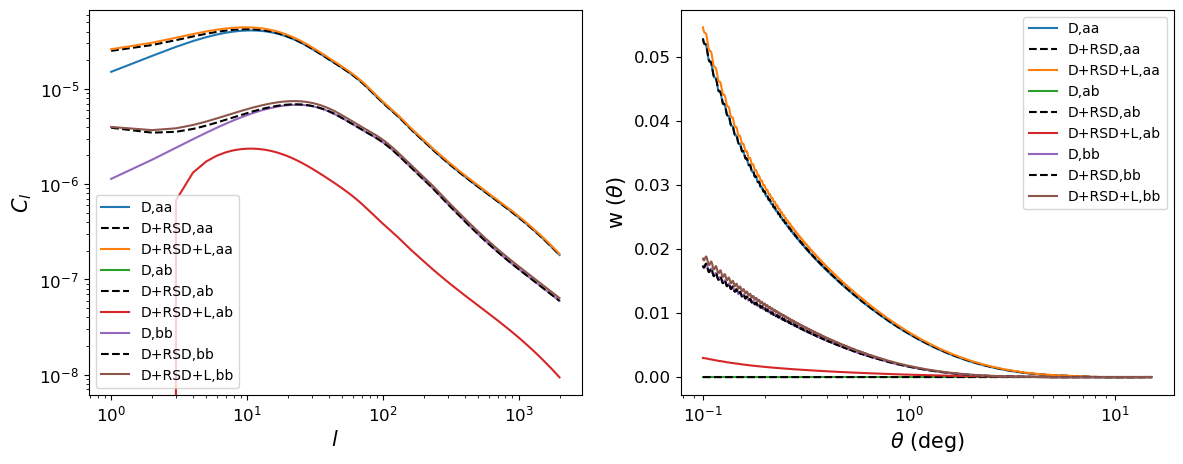

In [6]:
# Visualizing
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, cls_D_aa, label="D,aa")
axis[0].plot(ells, cls_D_RSD_aa, "--", color="k", label="D+RSD,aa")
axis[0].plot(ells, cls_D_RSD_L_aa, label="D+RSD+L,aa")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()

axis[1].plot(thetas, w_D_aa, label='D,aa')
axis[1].plot(thetas, w_D_RSD_aa,"--", color="k",label='D+RSD,aa')
axis[1].plot(thetas, w_D_RSD_L_aa,label='D+RSD+L,aa')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, cls_D_aa, label="D,aa")
axis[0].plot(ells, cls_D_RSD_aa, "--", color="k", label="D+RSD,aa")
axis[0].plot(ells, cls_D_RSD_L_aa, label="D+RSD+L,aa")
axis[0].plot(ells, cls_D_ab, label="D,ab")
axis[0].plot(ells, cls_D_RSD_ab, "--", color="k", label="D+RSD,ab")
axis[0].plot(ells, cls_D_RSD_L_ab, label="D+RSD+L,ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()

axis[1].plot(thetas, w_D_aa, label='D,aa')
axis[1].plot(thetas, w_D_RSD_aa,"--", color="k",label='D+RSD,aa')
axis[1].plot(thetas, w_D_RSD_L_aa,label='D+RSD+L,aa')
axis[1].plot(thetas, w_D_ab, label='D,ab')
axis[1].plot(thetas, w_D_RSD_ab,"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, w_D_RSD_L_ab,label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, cls_D_aa, label="D,aa")
axis[0].plot(ells, cls_D_RSD_aa, "--", color="k", label="D+RSD,aa")
axis[0].plot(ells, cls_D_RSD_L_aa, label="D+RSD+L,aa")
axis[0].plot(ells, cls_D_ab, label="D,ab")
axis[0].plot(ells, cls_D_RSD_ab, "--", color="k", label="D+RSD,ab")
axis[0].plot(ells, cls_D_RSD_L_ab, label="D+RSD+L,ab")
axis[0].plot(ells, cls_D_bb, label="D,bb")
axis[0].plot(ells, cls_D_RSD_bb, "--", color="k", label="D+RSD,bb")
axis[0].plot(ells, cls_D_RSD_L_bb, label="D+RSD+L,bb")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()

axis[1].plot(thetas, w_D_aa, label='D,aa')
axis[1].plot(thetas, w_D_RSD_aa,"--", color="k",label='D+RSD,aa')
axis[1].plot(thetas, w_D_RSD_L_aa,label='D+RSD+L,aa')
axis[1].plot(thetas, w_D_ab, label='D,ab')
axis[1].plot(thetas, w_D_RSD_ab,"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, w_D_RSD_L_ab,label='D+RSD+L,ab')
axis[1].plot(thetas, w_D_bb, label='D,bb')
axis[1].plot(thetas, w_D_RSD_bb,"--", color="k",label='D+RSD,bb')
axis[1].plot(thetas, w_D_RSD_L_bb,label='D+RSD+L,bb')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

### Variar Distribuições e ver incertezas dos ells

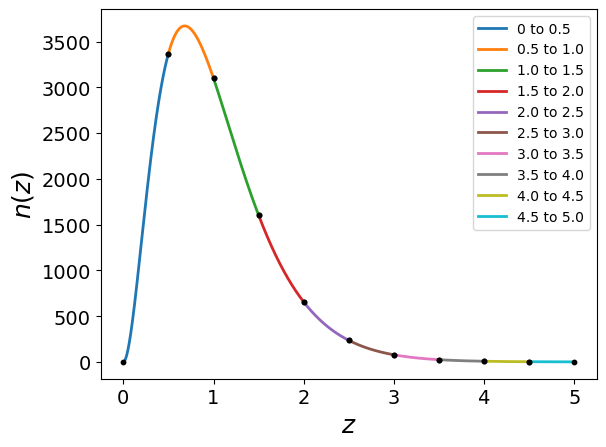

In [7]:
# Redshift distribution, p(z)
def p_z(z, z_0):
    return 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0)


def Distribution(z_min,z_max, step, Npts, func_p_z):
    N_intervals = len( np.arange(z_min,z_max,step) )
    all_zs = np.zeros((N_intervals, Npts))
    all_dNdzs = np.zeros((N_intervals, Npts))
    
    a = z_min
    i=0
    
    while a < z_max:
        b = round(a + step, 3)
        arr_z = np.linspace(a, b, Npts)
        pz = func_p_z(arr_z, z0)
        dNdz = Ngal * pz# Number density distribution       
        
        plt.xlabel('$z$',fontsize=18)
        plt.ylabel('$n(z)$',fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.plot(arr_z,dNdz, linewidth=2, label=F"{round(a,2)} to {round(b,2)}", zorder=1)
        plt.scatter(arr_z[0],dNdz[0], c="k", s=10,zorder=2)
        plt.scatter(arr_z[-1],dNdz[-1], c="k", s=10,zorder=2)
        
        all_zs[i,:] = arr_z
        all_dNdzs[i,:] = dNdz
        i +=1
        a = b
        
    plt.legend()
    plt.show()

    return all_zs, all_dNdzs

def Create_Tracers(cosmo, arr_z1, arr_z2, dNdz1, dNdz2, Npts):
    b_z = 1*np.ones(Npts) #Galaxy bias (constant with scale and z)
    s_z = 2*np.ones(Npts) #Lensing bias (constant with scale and z)
    # Criar tracers 
    Tracers= {}
    Tracers["D_a"]       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z), mag_bias = None, has_rsd=False)
    Tracers["D_RSD_a"]   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z), mag_bias = None, has_rsd=True)
    Tracers["D_RSD_L_a"] = ccl.NumberCountsTracer(cosmo, dndz=(arr_z1,dNdz1), bias=(arr_z1,b_z), mag_bias = (arr_z1,s_z), has_rsd=True)
    
    Tracers["D_b"]       = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z), mag_bias = None, has_rsd=False)
    Tracers["D_RSD_b"]   = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z), mag_bias = None, has_rsd=True)
    Tracers["D_RSD_L_b"] = ccl.NumberCountsTracer(cosmo, dndz=(arr_z2,dNdz2), bias=(arr_z2,b_z), mag_bias = (arr_z2,s_z), has_rsd=True)
    return Tracers

# Calcular Poderes espectrais angulares
def C_ells(cosmo, Tracers, ells):
    C_ls = {}
    C_ls["D_aa"]       = ccl.angular_cl(cosmo, Tracers["D_a"], Tracers["D_a"], ells)
    C_ls["D_RSD_aa"]   = ccl.angular_cl(cosmo, Tracers["D_RSD_a"], Tracers["D_RSD_a"], ells) 
    C_ls["D_RSD_L_aa"] = ccl.angular_cl(cosmo, Tracers["D_RSD_L_a"], Tracers["D_RSD_L_a"], ells)
    
    C_ls["D_bb"]       = ccl.angular_cl(cosmo, Tracers["D_b"], Tracers["D_b"], ells)
    C_ls["D_RSD_bb"]   = ccl.angular_cl(cosmo, Tracers["D_RSD_b"], Tracers["D_RSD_b"], ells) 
    C_ls["D_RSD_L_bb"] = ccl.angular_cl(cosmo, Tracers["D_RSD_L_b"], Tracers["D_RSD_L_b"], ells)
    
    C_ls["D_ab"]       = ccl.angular_cl(cosmo, Tracers["D_a"], Tracers["D_b"], ells)
    C_ls["D_RSD_ab"]   = ccl.angular_cl(cosmo, Tracers["D_RSD_a"], Tracers["D_RSD_b"], ells) 
    C_ls["D_RSD_L_ab"] = ccl.angular_cl(cosmo, Tracers["D_RSD_L_a"], Tracers["D_RSD_L_b"], ells)
    return C_ls

# Calcular Função de correlação
def Ang_Corr(cosmo, ells, C_ls, thetas ):
    ws = {}
    ws["D_aa"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_aa"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_aa"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_aa"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_aa"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_aa"], theta=thetas, type='NN', method='fftlog')
    
    ws["D_bb"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_bb"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_bb"]   = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_bb"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_bb"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_bb"], theta=thetas, type='NN', method='fftlog')
    
    ws["D_ab"]       = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_ab"], theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_ab"]   = ccl.correlation(cosmo, ell=ells, C_ell=np.abs(C_ls["D_RSD_ab"]), theta=thetas, type='NN', method='fftlog')
    ws["D_RSD_L_ab"] = ccl.correlation(cosmo, ell=ells, C_ell=C_ls["D_RSD_L_ab"], theta=thetas, type='NN', method='fftlog')
    return ws



# Definir um tipo de Universo
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)

# Definir uma Distribuição de Galáxias
i_lim = 26.0 # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744 # Constant, used to mimic observation
Ngal = 46. * 100.31  * (i_lim - 25.) # Normalisation, galaxies/arcmin^2


all_zs, all_dNdzs = Distribution(0, 5, 0.5, 10**3, p_z)

In [8]:
%%time
Tracers = Create_Tracers(cosmo,all_zs[0], all_zs[1], all_dNdzs[0], all_dNdzs[1], 10**3)

ells = np.arange(1, 2.5*10**3)
C_ls = C_ells(cosmo, Tracers, ells)

thetas = np.logspace(-1, np.log10(150), 10**3) # Theta is in degrees
ws = Ang_Corr(cosmo, ells, C_ls, thetas )

ells2 = np.arange(1, 10**1)
C_ls2 = C_ells(cosmo, Tracers, ells2)
ws2 = Ang_Corr(cosmo, ells2, C_ls2, thetas )

ells3 = np.arange(1, 5*10**2)
C_ls3 = C_ells(cosmo, Tracers, ells3)
ws3 = Ang_Corr(cosmo, ells3, C_ls3, thetas )

CPU times: user 1min 20s, sys: 442 ms, total: 1min 20s
Wall time: 10.4 s


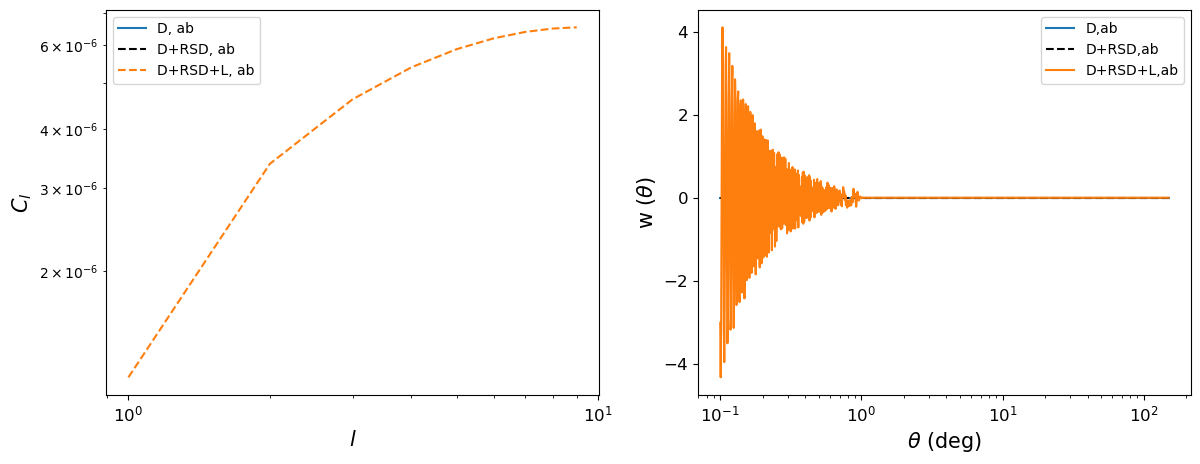

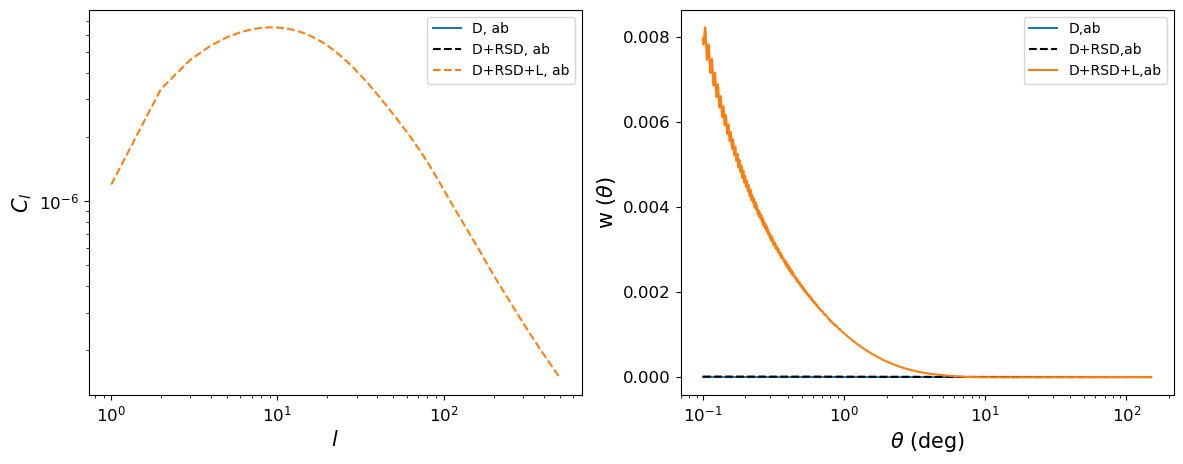


 ------------------



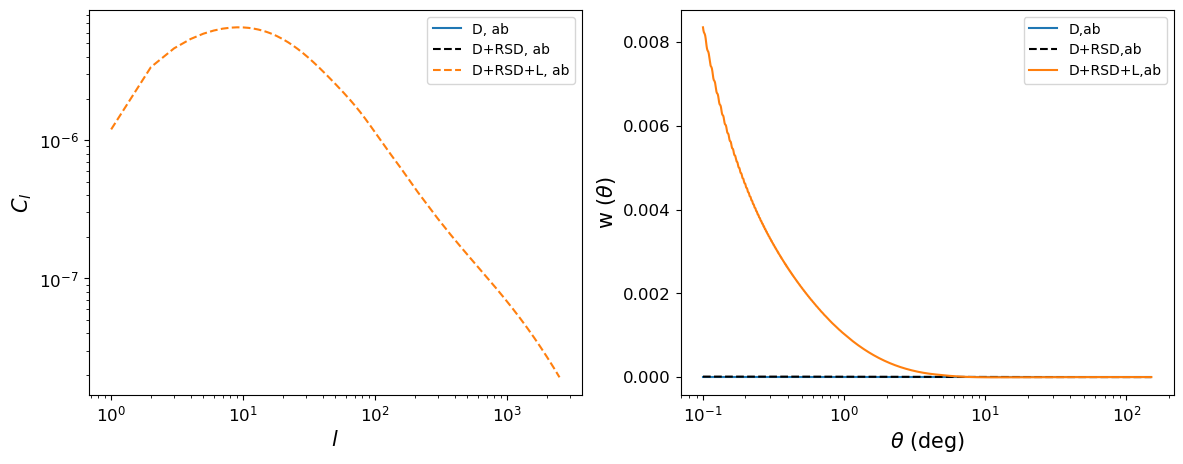

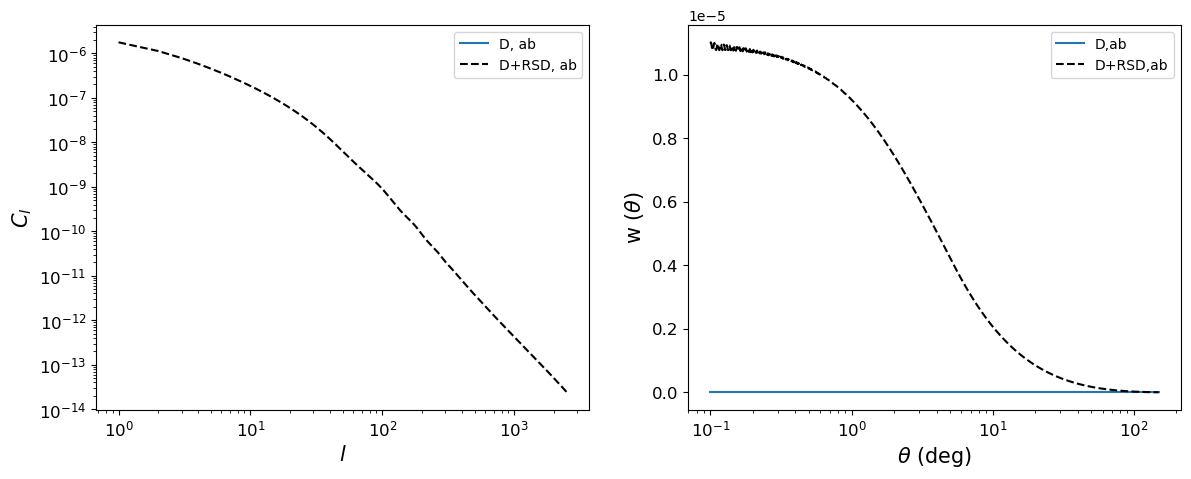

In [9]:
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells2, C_ls2["D_ab"], label="D, ab")
axis[0].plot(ells2, C_ls2["D_RSD_ab"], "--", color="k", label="D+RSD, ab")
axis[0].plot(ells2, C_ls2["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws2["D_ab"], label='D,ab')
axis[1].plot(thetas, ws2["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws2["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells3, C_ls3["D_ab"], label="D, ab")
axis[0].plot(ells3, C_ls3["D_RSD_ab"], "--", color="k", label="D+RSD, ab")
axis[0].plot(ells3, C_ls3["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws3["D_ab"], label='D,ab')
axis[1].plot(thetas, ws3["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws3["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

print("\n ------------------\n")

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, (C_ls["D_ab"]), label="D, ab")
axis[0].plot(ells, (C_ls["D_RSD_ab"]), "--", color="k", label="D+RSD, ab")
axis[0].plot(ells, C_ls["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws["D_ab"], label='D,ab')
axis[1].plot(thetas, ws["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, abs(C_ls["D_ab"]), label="D, ab")
axis[0].plot(ells, abs(C_ls["D_RSD_ab"]), "--", color="k", label="D+RSD, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws["D_ab"], label='D,ab')
axis[1].plot(thetas, ws["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

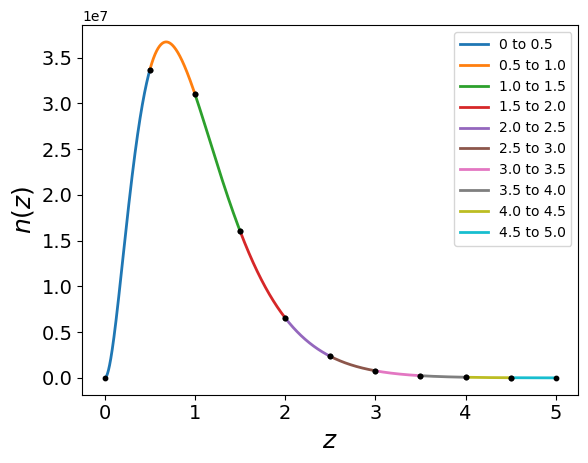

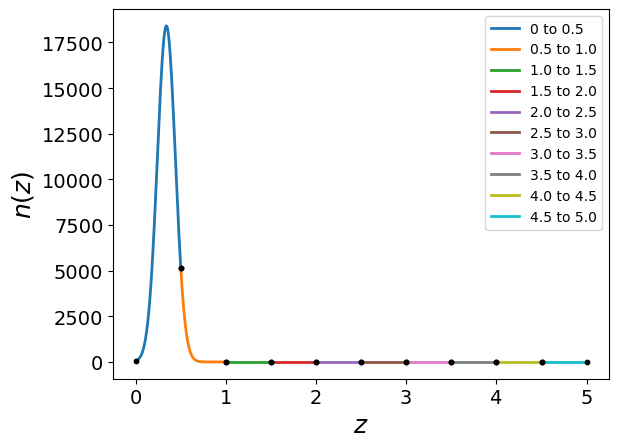

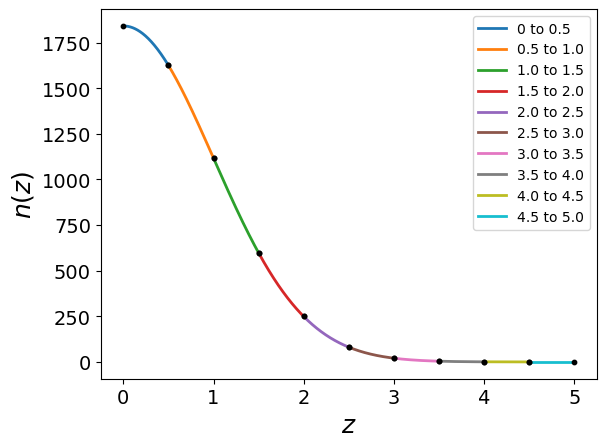

In [10]:
def p_z_amp(z, z_0):
    amp = 10**4
    return amp * 1./(2.*z_0) * (z / z_0)**2. * np.exp(-z/z_0)

def p_z_gauss(z, z_0):
    sigma = 0.1
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp( - 1/2 * ((z-z_0)/sigma)**2 )

def p_z_gauss_nor(z, z_0):
    sigma = 0.1
    return 1/np.sqrt(2*np.pi) * np.exp( - 1/2 * z**2 )

ells = np.arange(1, 2*10**3)
thetas = np.logspace(-1, np.log10(15), 10**3)

all_zs_amp, all_dNdzs_amp = Distribution(0, 5, 0.5, 10**3, p_z_amp)
Tracers_amp = Create_Tracers(cosmo,all_zs_amp[0], all_zs_amp[1], all_dNdzs_amp[0], all_dNdzs_amp[1], 10**3)
C_ls_amp = C_ells(cosmo, Tracers_amp, ells)
ws_amp = Ang_Corr(cosmo, ells, C_ls_amp, thetas )

all_zs_gauss, all_dNdzs_gauss = Distribution(0, 5, 0.5, 10**3, p_z_gauss)
Tracers_gauss = Create_Tracers(cosmo,all_zs_gauss[0], all_zs_gauss[1], all_dNdzs_gauss[0], all_dNdzs_gauss[1], 10**3)
C_ls_gauss = C_ells(cosmo, Tracers_gauss, ells)
ws_gauss = Ang_Corr(cosmo, ells, C_ls_gauss, thetas )

all_zs_gauss_nor, all_dNdzs_gauss_nor = Distribution(0, 5, 0.5, 10**3, p_z_gauss_nor)
Tracers_gauss_nor = Create_Tracers(cosmo,all_zs_gauss_nor[0], all_zs_gauss[1], all_dNdzs_gauss_nor[0], all_dNdzs_gauss_nor[1], 10**3)
C_ls_gauss_nor = C_ells(cosmo, Tracers_gauss_nor, ells)
ws_gauss_nor = Ang_Corr(cosmo, ells, C_ls_gauss_nor, thetas )

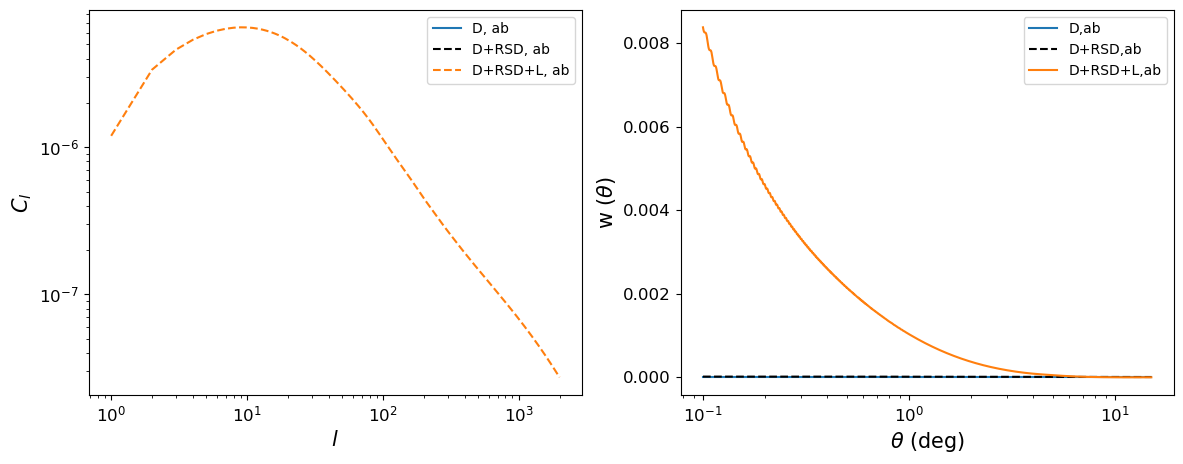

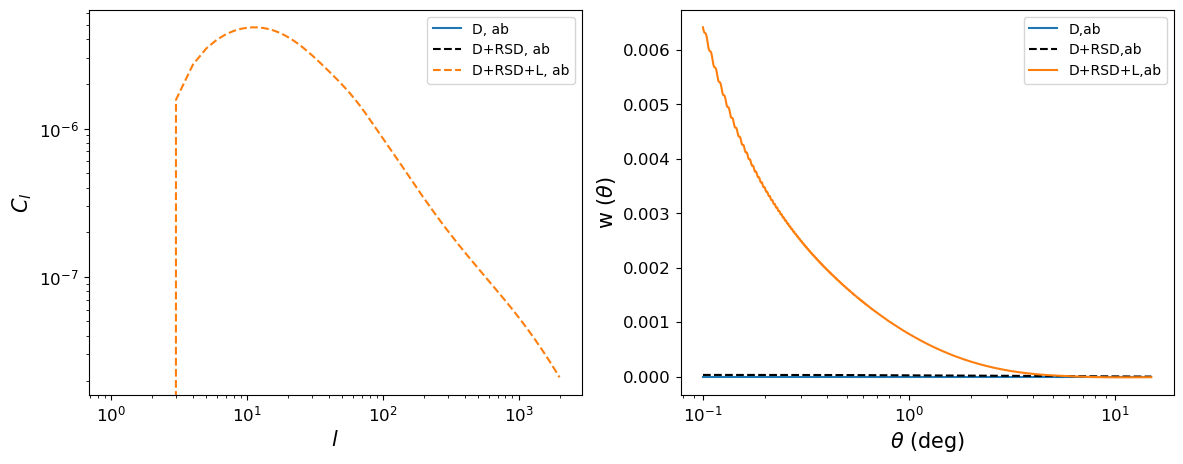

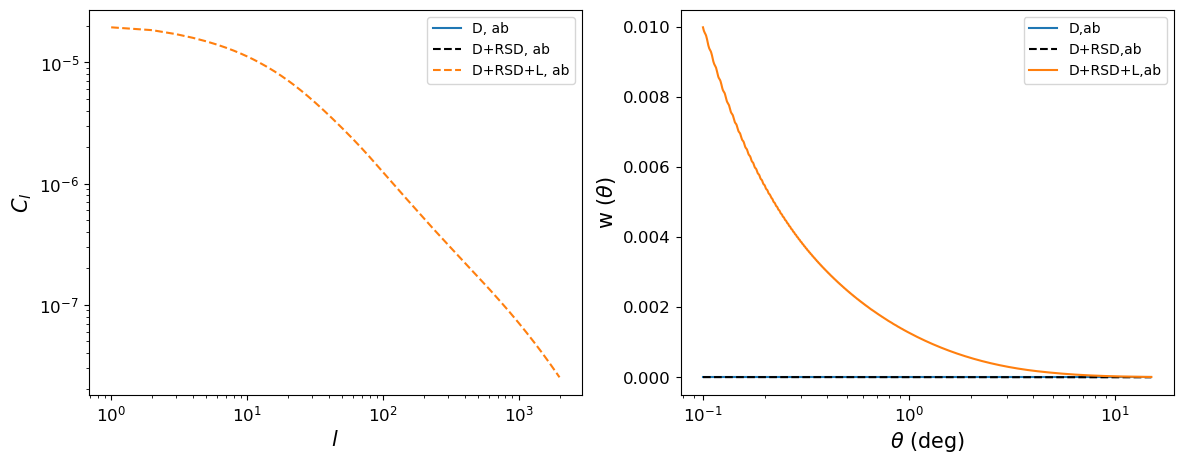

In [11]:
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, C_ls_amp["D_ab"], label="D, ab")
axis[0].plot(ells, C_ls_amp["D_RSD_ab"], "--", color="k", label="D+RSD, ab")
axis[0].plot(ells, C_ls_amp["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws_amp["D_ab"], label='D,ab')
axis[1].plot(thetas, ws_amp["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws_amp["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, C_ls_gauss["D_ab"], label="D, ab")
axis[0].plot(ells, C_ls_gauss["D_RSD_ab"], "--", color="k", label="D+RSD, ab")
axis[0].plot(ells, C_ls_gauss["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws_gauss["D_ab"], label='D,ab')
axis[1].plot(thetas, ws_gauss["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws_gauss["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, C_ls_gauss_nor["D_ab"], label="D, ab")
axis[0].plot(ells, C_ls_gauss_nor["D_RSD_ab"], "--", color="k", label="D+RSD, ab")
axis[0].plot(ells, C_ls_gauss_nor["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[1].plot(thetas, ws_gauss_nor["D_ab"], label='D,ab')
axis[1].plot(thetas, ws_gauss_nor["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws_gauss_nor["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w $(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
plt.show()

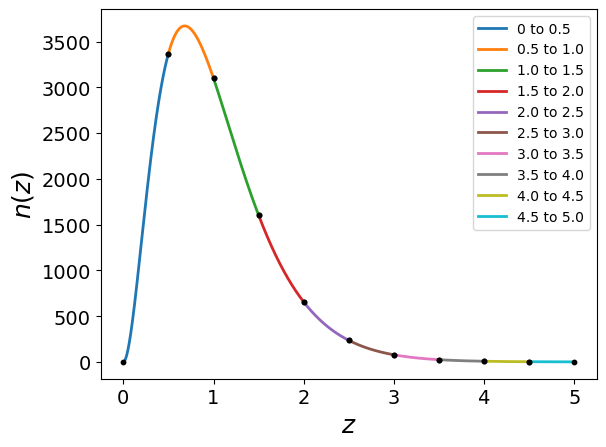

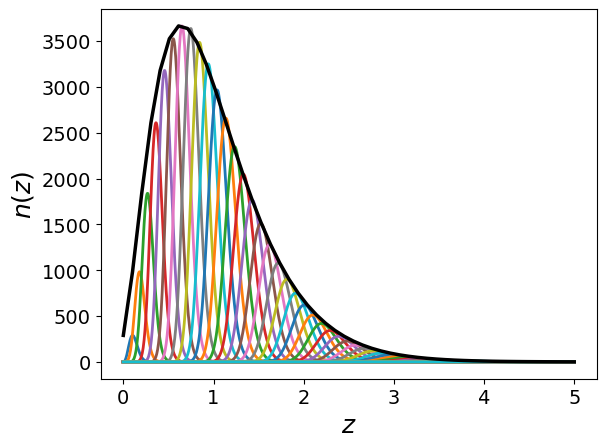

NUmber of lines = 50 

CPU times: user 763 ms, sys: 9.96 ms, total: 773 ms
Wall time: 771 ms


In [166]:
%%time
def p_z_GD(z, z_c, z0):
    sigma_z = 0.05*(1+z)
    Gaussian_term = np.exp(- (z-z_c)**2 / (2*sigma_z**2))
    return 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) * Gaussian_term

def Distribution_gauss(z_min,z_max, step, Npts, func_p_z, z0):
    N_intervals = len( np.arange(z_min,z_max,step) )
    all_dNdzs = np.zeros((N_intervals, Npts))
    all_zs = np.linspace(z_min, z_max, Npts)
    
    max_dndz = np.zeros(N_intervals)
    arr_z_c = np.zeros(N_intervals)
    a = z_min
    i=0
    
    while a < z_max:
        b = round(a + step, 3)
        arr_z = np.linspace(a, b, Npts)
        z_c = arr_z[int(Npts/2)] 
        
        pz = func_p_z(all_zs, z_c, z0)
        dNdz = Ngal * pz    
        
        plt.xlabel('$z$',fontsize=18)
        plt.ylabel('$n(z)$',fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.plot(all_zs,dNdz, linewidth=2, label=F"{round(a,2)} to {round(b,2)}")
        
        all_dNdzs[i,:] = dNdz
        max_dndz[i] = np.max(dNdz) 
        arr_z_c[i] = z_c 
        i +=1
        a = b

    arr_max = np.linspace(z_min,z_max, N_intervals) 
    plt.plot(arr_max, max_dndz, lw=2.5, color="k")
    plt.show()

    print("NUmber of lines =",N_intervals,"\n")

    return all_zs, all_dNdzs, max_dndz, arr_z_c


cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
i_lim = 26.0 
z0 = 0.0417*i_lim - 0.744 
Ngal = 46. * 100.31  * (i_lim - 25.)

Npts = 10**3
ells = np.arange(1, Npts)
thetas = np.logspace(-1, np.log10(15), Npts) 

all_zs, all_dNdzs = Distribution(0, 5, 0.5, Npts, p_z)
##########
all_zs_GD, all_dNdzs_GD , sum_dNdzs , arr_z_c = Distribution_gauss(0, 5, 0.1, Npts, p_z_GD, z0)

In [127]:
index_line_a = 5
index_line_b = 6

Tracers_GD = Create_Tracers(cosmo, all_zs_GD, all_zs_GD, all_dNdzs_GD[index_line_a], all_dNdzs_GD[index_line_b], Npts)
C_ls_GD = C_ells(cosmo, Tracers_GD, ells)
ws_GD = Ang_Corr(cosmo, ells, C_ls_GD, thetas )

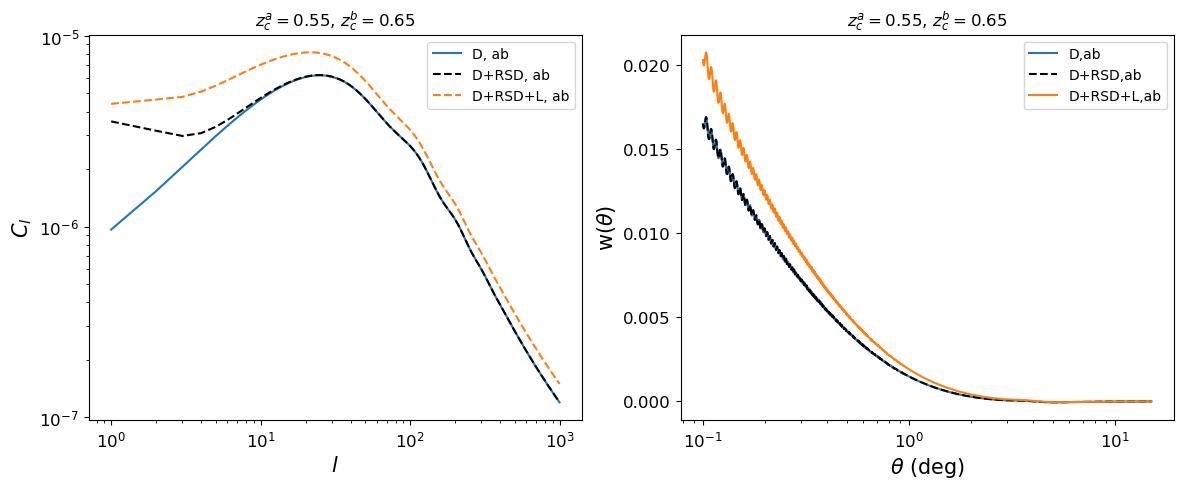

In [128]:
fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
axis[0].plot(ells, C_ls_GD["D_ab"], label="D, ab")
axis[0].plot(ells, C_ls_GD["D_RSD_ab"], "--", color="k", label="D+RSD, ab")
axis[0].plot(ells, C_ls_GD["D_RSD_L_ab"], "--", label="D+RSD+L, ab")
axis[0].set_xscale('log')
axis[0].set_yscale('log')
axis[0].set_xlabel('$l$',fontsize=15)
axis[0].set_ylabel('$C_l$',fontsize=15)
axis[0].tick_params(axis='x', labelsize=12)
axis[0].tick_params(axis='y', labelsize=12)
axis[0].legend()
axis[0].set_title(F"$z_c^a ={arr_z_c[index_line_a] :.2f}$, $z_c^b ={arr_z_c[index_line_b] :.2f}  $")
axis[1].plot(thetas, ws_GD["D_ab"], label='D,ab')
axis[1].plot(thetas, ws_GD["D_RSD_ab"],"--", color="k",label='D+RSD,ab')
axis[1].plot(thetas, ws_GD["D_RSD_L_ab"],label='D+RSD+L,ab')
axis[1].set_xscale('log')
axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
axis[1].set_ylabel(r'w$(\theta)$',fontsize=15)
axis[1].tick_params(axis='x', labelsize=12)
axis[1].tick_params(axis='y', labelsize=12)
axis[1].legend()
axis[1].set_title(F"$z_c^a ={arr_z_c[index_line_a] :.2f}$, $z_c^b ={arr_z_c[index_line_b] :.2f}  $")
plt.show()

Agora que ja tenho isto com gaussianas o spline ja funciona para valores maiores de ell

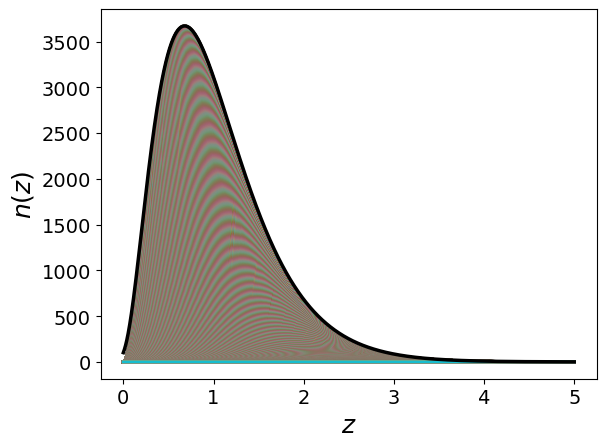

NUmber of lines = 5000 

CPU times: user 46.9 s, sys: 610 ms, total: 47.5 s
Wall time: 47.5 s


In [168]:
%%time
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.83, n_s = 0.96)
i_lim = 26.0 
z0 = 0.0417*i_lim - 0.744 
Ngal = 46. * 100.31  * (i_lim - 25.)

Npts = 10**4
all_zs_GD2, all_dNdzs_GD2 , sum_dNdzs2 , arr_z_c2 = Distribution_gauss(0, 5, 0.001, Npts, p_z_GD, z0)

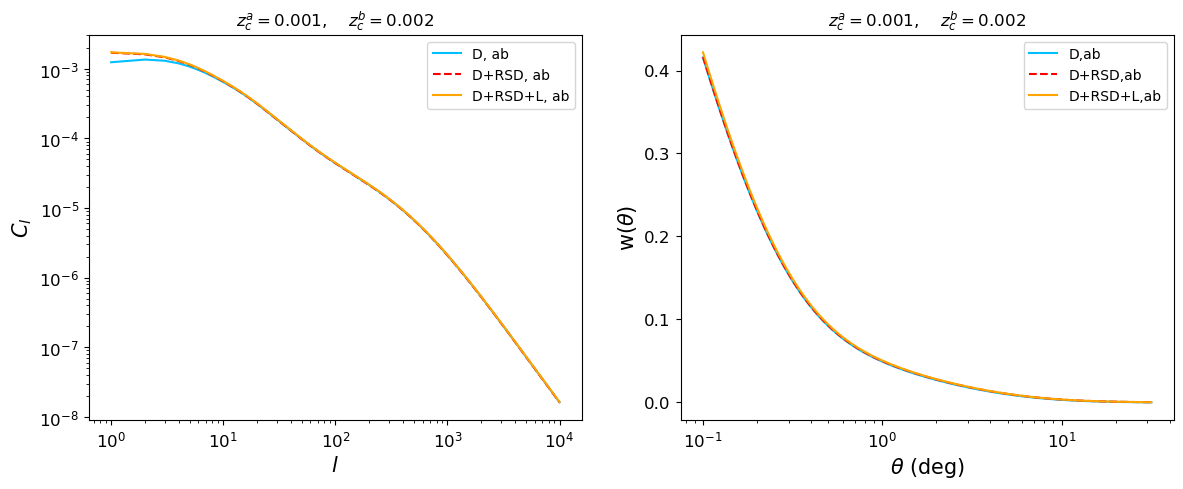

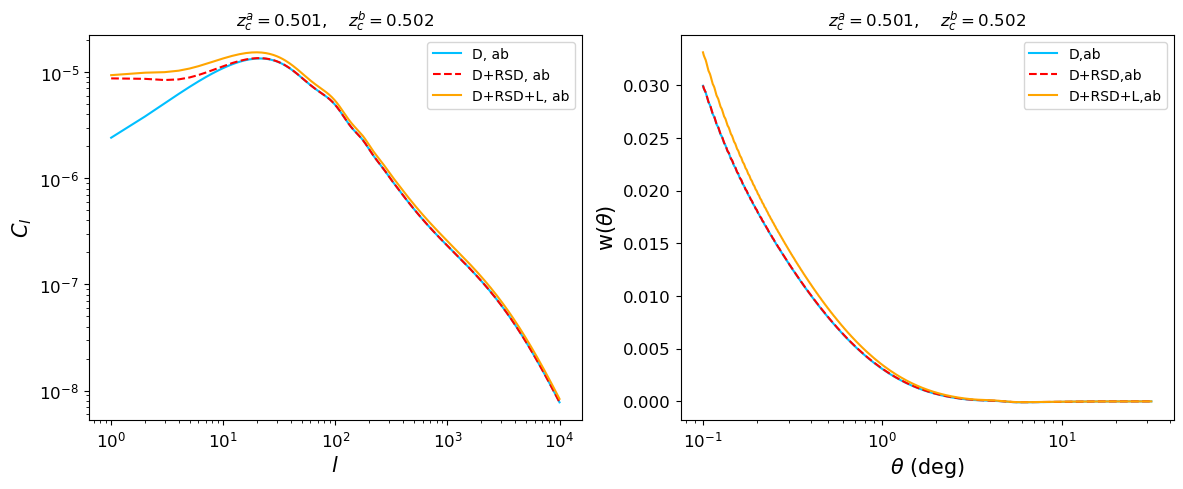

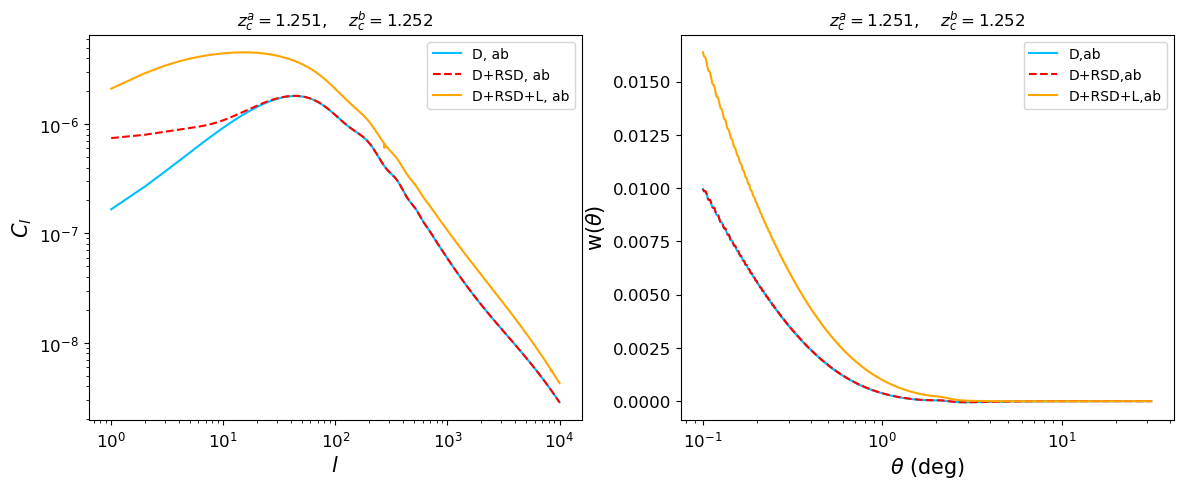

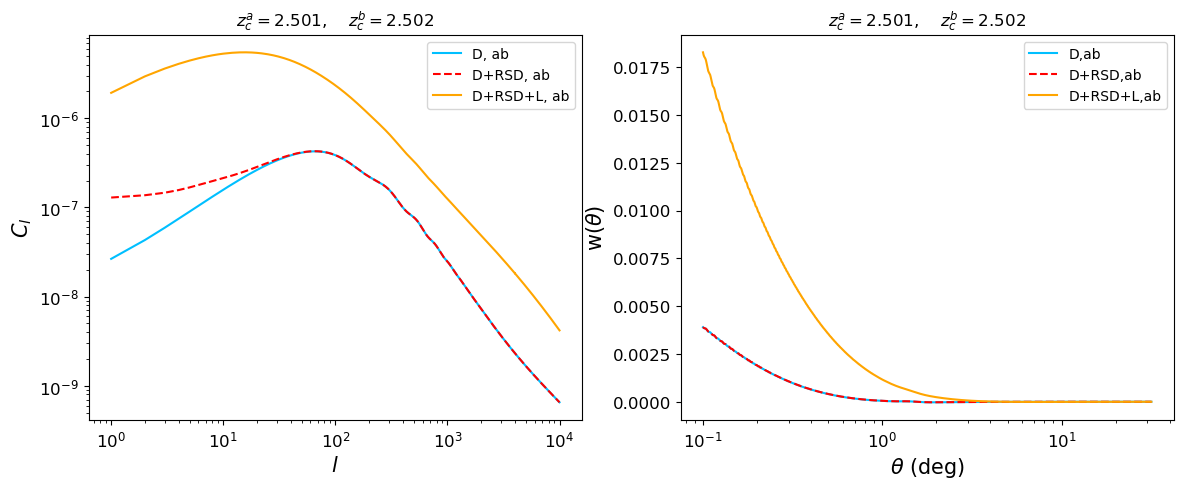

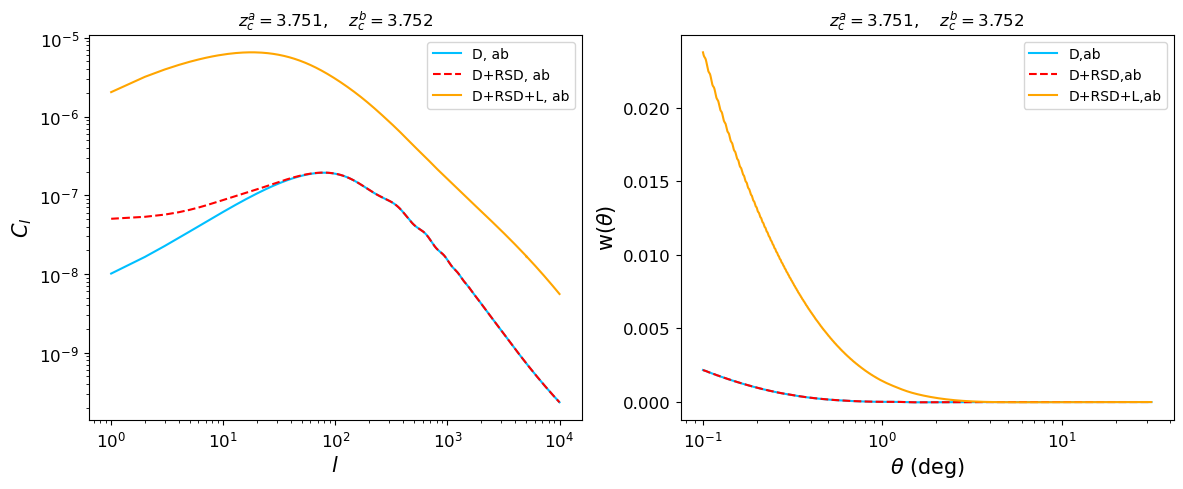

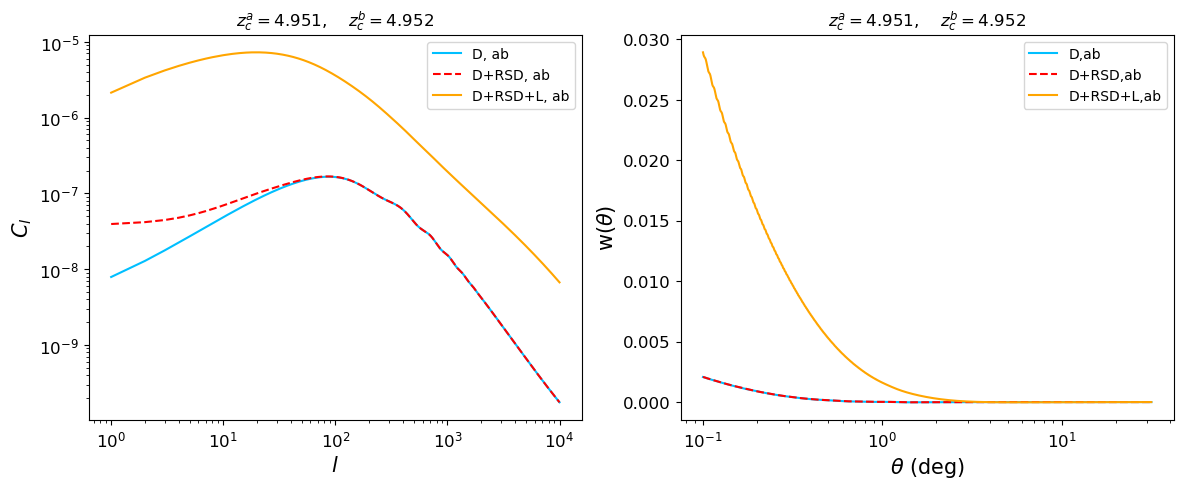

CPU times: user 7min 41s, sys: 667 ms, total: 7min 42s
Wall time: 1min 3s


In [177]:
%%time 

ells2 = np.arange(1, Npts)
thetas2 = np.logspace(-1, 1.5, Npts) 

list_values = np.array([0, 0.1, 0.25, 0.5, 0.75, 0.99]) * len(arr_z_c2)
for value in list_values:
    index_line_a = int(0 + value)
    index_line_b = int(1 + value)
    Tracers_GD2 = Create_Tracers(cosmo, all_zs_GD2, all_zs_GD2, all_dNdzs_GD2[index_line_a], all_dNdzs_GD2[index_line_b], Npts)
    C_ls_GD2 = C_ells(cosmo, Tracers_GD2, ells2)
    ws_GD2 = Ang_Corr(cosmo, ells2, C_ls_GD2, thetas2 )
    
    fig, axis = plt.subplots(ncols=2,nrows=1,figsize=(14,5))
    axis[0].plot(ells2, C_ls_GD2["D_ab"],           c="deepskyblue", label="D, ab")
    axis[0].plot(ells2, C_ls_GD2["D_RSD_ab"], "--", c="red",         label="D+RSD, ab")
    axis[0].plot(ells2, C_ls_GD2["D_RSD_L_ab"],     c="orange",      label="D+RSD+L, ab")
    axis[0].set_xscale('log')
    axis[0].set_yscale('log')
    axis[0].set_xlabel('$l$',fontsize=15)
    axis[0].set_ylabel('$C_l$',fontsize=15)
    axis[0].tick_params(axis='x', labelsize=12)
    axis[0].tick_params(axis='y', labelsize=12)
    axis[0].legend()
    axis[0].set_title(Fr"$z_c^a ={arr_z_c2[index_line_a] :.3f}$, $\quad z_c^b ={arr_z_c2[index_line_b] :.3f} $")
    
    axis[1].plot(thetas2, ws_GD2["D_ab"],          c="deepskyblue", label='D,ab')
    axis[1].plot(thetas2, ws_GD2["D_RSD_ab"],"--", c="red",         label='D+RSD,ab')
    axis[1].plot(thetas2, ws_GD2["D_RSD_L_ab"],    c="orange",      label='D+RSD+L,ab')
    axis[1].set_xscale('log')
    axis[1].set_xlabel(r'$\theta$ (deg)',fontsize=15)
    axis[1].set_ylabel(r'w$(\theta)$',fontsize=15)
    axis[1].tick_params(axis='x', labelsize=12)
    axis[1].tick_params(axis='y', labelsize=12)
    axis[1].legend()
    axis[1].set_title(Fr"$z_c^a ={arr_z_c2[index_line_a] :.3f}$, $\quad z_c^b ={arr_z_c2[index_line_b] :.3f} $")
    plt.show()

O que isto demonstra é que quanto maior for o redshift maior é o impacto do lensing nas nossas observações ?